In [393]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
sys.path.append("..")
from utils.model3 import Net_mask
#from utils.data import Data
from utils.loss_experiment import Loss
#from utils.lr_scheduler import lr_scheduler
#from utils.weights import set_weights
#from scripts.parameters import get_parameters
#
import os
import shutil

from torch.distributions.multivariate_normal import MultivariateNormal

In [394]:
n_param = 10
n_data = 100000
tensor_data = torch.zeros(n_data, 2*n_param)
tensor_d_sample =  MultivariateNormal(loc=torch.zeros(n_param), covariance_matrix=torch.eye(n_param)).sample(sample_shape=(n_data,))
tensor_n_masked = torch.randint(n_param, (n_data,))
tensor_masks = torch.rand(n_data, n_param).argsort(dim=1)
tensor_masks = (tensor_masks < tensor_n_masked.unsqueeze(1))*1
tensor_data[:,:n_param] = tensor_d_sample*tensor_masks
tensor_data[:,n_param:] = tensor_masks
tensor_batch = tensor_data

In [395]:
tensor_eval = torch.zeros(n_data, 2*n_param)
tensor_batch.shape
tensor_eval[:,10:] = tensor_batch[:,10:]
tensor_eval

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [396]:
tensor_D = torch.tensor(
    [[1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0,  1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0,  0, 1, -1, 0, 0, 0, 0, 0],
    [0, 0,  0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0,  0, 0, 0, 1, -1, 0, 0, 0],
    [0, 0,  0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0,  0, 0, 0, 0, 0, 1, -1, 0],
    [0, 0,  0, 0, 0, 0, 0, 0, 1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=torch.float
)
tensor_Q_m = torch.mm(torch.t(tensor_D), tensor_D) 
n_param = tensor_D.size(dim=0)
vu = 1000
inversion_scaling = 1./vu
tensor_Q_m_modified = tensor_Q_m + torch.ones(n_param, n_param)*inversion_scaling


tensor_eval = torch.zeros(n_data, 2*n_param)

sigma2 = 0.01
tensor_mu_m = torch.zeros(n_param)
tensor_Sigma_m = torch.inverse(tensor_Q_m_modified)
tensor_Sigma_eps = torch.eye(n_param)*sigma2
tensor_mu_eps = tensor_mu_m 

for i in range(n_data):
    input_tensor = tensor_batch[i,:]
    d = input_tensor[:n_param]
    mask = input_tensor[n_param:]
    location = torch.where(mask > 0.5)
    d = d[location]
    n_data = len(d)
    G = torch.zeros(n_data, n_param)
    for idx, elem in enumerate(location[0]):
        G[idx, elem] = 1
    Sigma_eps = torch.matmul(G, torch.matmul(tensor_Sigma_eps, torch.t(G)))
    mu_eps = torch.matmul(G, tensor_mu_eps)

    #matrix calculations
    Sigma_mm = tensor_Sigma_m
    Sigma_dm = torch.matmul(G,Sigma_mm)
    Sigma_md = torch.matmul(Sigma_mm, torch.t(G))
    Sigma_dd = torch.matmul(G, torch.matmul(Sigma_mm, torch.t(G))) + Sigma_eps
    Sigma_dd_inv = torch.inverse(Sigma_dd)
    mu_m_d = tensor_mu_m + torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv),(d-mu_eps))
    Sigma_m_d = Sigma_mm - torch.matmul(torch.matmul(Sigma_md, Sigma_dd_inv), Sigma_dm)
    tensor_eval[i,:10] = mu_m_d

In [397]:
tensor_eval[5,:].shape
mu_m_d.shape

torch.Size([10])

(-0.5, 9.5, -3.0, 3.0)

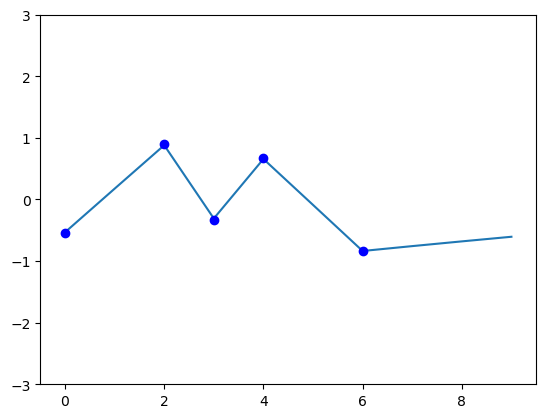

In [398]:
ind = 15
#print(mu_m_d)
#print(tensor_batch[ind,:])
plt.plot(range(10), tensor_eval[ind,:10])
mask = tensor_batch[ind,10:]
boo_arr = mask > 0.5
#print(boo_arr)
values = tensor_batch[ind,:10][boo_arr]
location_raw = torch.where(mask > 0.5)
location = location_raw[0]
plt.plot(location, values, 'bo')
plt.axis([-0.5, 9.5, -3, 3])
#print(location)

In [399]:
tensor_eval[:,:10].shape

torch.Size([100000, 10])

In [404]:
tensor_output = tensor_eval[:,:10]
tensor_input = tensor_batch

tensor_Psi = tensor_output
tensor_Gd = tensor_input[:,:n_param]
tensor_mask = tensor_input[:,n_param:]
tensor_GPsi = tensor_Psi*tensor_mask

# data residual loss
tensor_squared_error = torch.square(tensor_GPsi - tensor_Gd)
tensor_squared_error_sum = torch.sum(tensor_squared_error, [0, 1])
tensor_data_fit_loss = tensor_squared_error_sum
print(tensor_data_fit_loss/100/1000)

# data regularization loss
tensor_PsiQ_m = torch.matmul(tensor_Psi, tensor_Q_m)
tensor_PsiQ_m = torch.unsqueeze(tensor_PsiQ_m, 1)
tensor_Psi = torch.unsqueeze(tensor_Psi, 2)
tensor_PsiQ_mPsi = torch.bmm(tensor_PsiQ_m, tensor_Psi).squeeze(2)
tensor_data_regularization_loss = torch.sum(tensor_PsiQ_mPsi)
print(tensor_data_regularization_loss/100/1000)

tensor(0.0016)
tensor(6.3504)
